In [1]:
import os, pickle
from tqdm import tqdm  # Import tqdm for progress tracking
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm
import pyemma
import pyemma.coordinates as coor
from joblib import Parallel, delayed


## Load in important functions

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)
    

In [3]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

## Prepare the Data and the log (indicating of the data state)

In [4]:
all_omegas = [] # Load in the omega values for all replicas

for state in range(3):  # Adjust the range to include all replicas
    omega_path = f"omega_data/omegas_state{state}.pkl"
    omegas = Data.load(omega_path)
    omegas = omegas.array_list
    all_omegas.append(np.array(omegas))
    
all_omegas = np.array(all_omegas)  # (nreps, nsnaps, nresidues)
print('all_omegas.shape', all_omegas.shape)

# Arrange each snapshot by replica (not temp)
replica_indices = np.loadtxt('state_new.dat')
print("replica_indices.shape", replica_indices.shape)
#print(replica_indices)

# Convert the data into cistrans 
all_cistrans = omega2cistrans(all_omegas)
print('all_omegas.shape', all_omegas.shape)

start = 0
nsnaps = 337514
nreps = 3
nres = 3

all_omegas_by_replica_and_state = np.zeros((nreps, nsnaps, nres + 1))


for i in range(nsnaps):
    Ind = np.argsort(replica_indices[i, :]) # find the index of replica
    all_omegas_by_replica_and_state[:, i, :-1] = all_cistrans[Ind, i, :]
    all_omegas_by_replica_and_state[:, i, -1] = Ind  # State is found by indexing
    #print(all_omegas_by_replica_and_state)

print(replica_indices[:3, :])
all_omegas_by_replica_and_state[:, :3, :]

all_omegas.shape (3, 337514, 3)
replica_indices.shape (337514, 3)
all_omegas.shape (3, 337514, 3)
[[0. 1. 2.]
 [0. 1. 2.]
 [1. 0. 2.]]


array([[[1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 1.]],

       [[0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 2.],
        [0., 0., 0., 2.],
        [0., 0., 0., 2.]]])

## Functions 

In [5]:
def state_to_index_vectorized(all_state):
    """
    Converts a (N, M, 4) array of states into (N, M) indices in [0..23].

    Assumes:
      - The first three entries in the state are binary bits (0 or 1).
      - The last entry is an integer in [0..2].
      - If any of the four entries is NaN, the output is NaN for that row.

    Parameters
    ----------
    all_state : array-like
        An array of shape (N, M, 4).

    Returns
    -------
    indexed_states : ndarray
        A float array of shape (N, M). Valid rows are in the range [0..23].
        Rows with NaNs in the input remain NaN.
    """
    import numpy as np

    all_state_array = np.array(all_state, dtype=float)

    if all_state_array.ndim != 3 or all_state_array.shape[-1] != 4:
        raise ValueError(f"Unexpected shape: {all_state_array.shape}, expected (N, M, 4).")

    nan_mask = np.isnan(all_state_array).any(axis=-1)
    indexed_states = np.full(all_state_array.shape[:-1], np.nan, dtype=float)

    valid_mask = ~nan_mask
    weights = np.array([12, 6, 3, 1], dtype=float)  # Adjusted for last entry in [0,1,2]
    valid_data = all_state_array[valid_mask]
    results = valid_data @ weights
    indexed_states[valid_mask] = results

    return indexed_states

In [6]:
def index_to_state(index):
    """
    Converts an index (0..23) into a (4,) array where the first three
    entries are bits (0 or 1) and the last entry is in [0..2].
    
    Inverse of:
        index = 12*a + 6*b + 3*c + x,
    where a, b, c ∈ {0,1}, x ∈ [0..2]
    """
    if not (0 <= index < 24):
        raise ValueError(f"Index out of range: {index}. Expected 0..23.")

    x = index % 3
    remainder = index // 3  # Gives 0..7

    c = remainder % 2
    b = (remainder // 2) % 2
    a = (remainder // 4) % 2

    return np.array([a, b, c, x], dtype=int)


In [7]:
def compute_transition_matrix(subset, num_states, lagtime, pseudocount=0.25):
    """Compute transition matrix for a given subset of trajectories."""
    
    C = np.zeros((num_states, num_states))  # Initialize count matrix

    for traj in subset:
        for t in range(len(traj) - lagtime):
            from_state = traj[t]
            to_state = traj[t + lagtime]

            # Skip NaN transitions
            if np.isnan(from_state) or np.isnan(to_state):
                continue

            # Convert states to integers for indexing
            from_state = int(from_state)
            to_state = int(to_state)

            # Count transitions
            C[from_state, to_state] += 1.0

    # Add pseudocounts to avoid zero entries
    C += pseudocount

    # Normalize rows to get probabilities
    row_sums = C.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Prevent division by zero
    T = C / row_sums        
    
    return T

In [8]:
def get_transition_matrices(n_trajs, num_states, lagtime, cluster_size=10, pseudocount=0.25, n_jobs=-1):
    """
    Compute transition matrices for subsets of trajectories in parallel.
    """

    num_trajs = n_trajs.shape[0]  # Number of trajectories
    
    # Shuffle indices
    indices = np.arange(num_trajs)
    np.random.shuffle(indices)

    # Split into clusters
    clusters = [indices[i:i + cluster_size] for i in range(0, num_trajs, cluster_size)]

    # Merge last small cluster with the second-last if needed
    if len(clusters) > 1 and len(clusters[-1]) < cluster_size:
        clusters[-2] = np.concatenate([clusters[-2], clusters[-1]])  
        clusters.pop()

    # Parallel computation of transition matrices
    def process_cluster(cluster):
        subset = n_trajs[cluster]
        # Call your existing compute_transition_matrix
        T = compute_transition_matrix(subset, num_states, lagtime, pseudocount)
        return T

    # Use joblib's Parallel for parallelism. 
    # `delayed(process_cluster)(c)` calls `process_cluster(c)` lazily.
    # `n_jobs=-1` uses all available CPUs unless specified otherwise.
    transition_matrices = Parallel(n_jobs=n_jobs)(
        delayed(process_cluster)(cluster) 
        for cluster in tqdm(clusters, desc="Computing transition matrices", unit="cluster")
    )

    return transition_matrices


In [9]:
def compute_stationary_distribution(T, lagtime):
    """Compute the stationary distribution of a transition matrix T.
    
    INPUT:
    T - Transition matrix where T_ij is the probability of transitioning i -> j.
    
    RETURN:
    pi - The stationary distribution (1D NumPy array).
    t2 - The implied timescale (in units of steps).
    """
    try:
        # Compute the implied timescale
        evals = np.linalg.eigvals(T.transpose() )  # will be something like [0.99754545 1.        ]
        evals_sorted = np.sort(evals)      # ascending order
        mu2 = evals_sorted[-2]            # second-largest eigenvalue
        #print('mu2', mu2, 'evals', evals, 'evals_sorted', evals_sorted, 'T', T)
        
        t2 = -1.0*lagtime/np.log(mu2.real)  # the implied timescale relation
        #print('evals_sorted', evals_sorted, 'mu2', mu2, 't2', t2)

        # Compute the stationary state distribution 
        n_states = T.shape[0]
        A = np.transpose(T) - np.eye(n_states)  # (T' - I)
        A = np.vstack([A, np.ones(n_states)])  # Append normalization row
        b = np.zeros(n_states + 1)
        b[-1] = 1  # Ensure probability sums to 1
        
        # Solve for stationary distribution using least squares
        pi, *_ = np.linalg.lstsq(A, b, rcond=None)
        
        # Ensure non-negative values and normalize
        pi = np.maximum(pi, 0)  # Prevent small negative values due to numerical error
        pi /= np.sum(pi)  # Normalize to sum to 1

    except Exception as e:
        print(f"Error computing stationary distribution: {e}")
        t2 = np.nan
        pi = None

    return pi, t2

## Calculating the stationary population and implied timescale

In [10]:
traj = all_omegas_by_replica_and_state
print('traj.shape', traj.shape)

traj_indexed = state_to_index_vectorized(traj)
print('traj_indexed.shape', traj_indexed.shape)
traj_indexed


traj.shape (3, 337514, 4)
traj_indexed.shape (3, 337514)


array([[18., 18., 19., ...,  4.,  4.,  4.],
       [ 1.,  1.,  0., ..., 20., 20., 20.],
       [ 2.,  2.,  2., ..., 21., 21., 21.]])

In [11]:
save_path = f"omega_data/all_omegas.pkl"
rep_object = Data(traj)
rep_object.save(save_path)

In [12]:
print('traj.shape', traj.shape)

traj_indexed = state_to_index_vectorized(traj)
print('traj_indexed.shape', traj_indexed.shape)
traj_indexed

traj.shape (3, 337514, 4)
traj_indexed.shape (3, 337514)


array([[18., 18., 19., ...,  4.,  4.,  4.],
       [ 1.,  1.,  0., ..., 20., 20., 20.],
       [ 2.,  2.,  2., ..., 21., 21., 21.]])

In [13]:
def process_trajectory(n_trajs, lagtime, num_states, cluster_size):

    # Calculate the transition matrix 
    transition_matrices = get_transition_matrices(n_trajs, num_states, lagtime, cluster_size, pseudocount=0.25, n_jobs=-1)
    transition_matrices = np.array(transition_matrices)
    #print('transition_matrices.shape', transition_matrices.shape)

    # Calculate the stationary population 
    pi_all = []
    t2_all = []

    
    for T in transition_matrices:
        pi, t2 = compute_stationary_distribution(T, lagtime)
        pi_all.append(pi)
        t2_all.append(t2)

    pi_all = np.array(pi_all)
    t2_all = np.array(t2_all)


    t2_mean = np.exp(np.mean([np.log(t2) for t2 in t2_all]))
    t2_std = np.exp(np.sqrt(np.var([np.log(t2) for t2 in t2_all])))
    pi_means = np.mean(pi_all, axis=0)  # Mean across trajectories
    pi_std = np.std(pi_all, axis=0)  # Standard deviation   
    
    return pi_means, pi_std, t2_mean, t2_std

#print(pi_all)

In [14]:
n_trajs = traj_indexed
num_states = 24
#lagtimes = [1]
lagtimes = [5, 10, 25, 50] + list(range(100, 337514, 500))
#lagtimes = [5, 10, 25, 50]
dt_in_ns = 0.004  
cluster_size = 1

# Store results
pi_all_means = []
pi_all_uppers = []
pi_all_lowers = []
pi_all_stds = []

# Store results
t2_all_means = []
t2_all_uppers = []
t2_all_lowers = []
t2_all_stds = []

for lagtime in tqdm(lagtimes, desc="Processing Lag Times", unit="lag"):
    
    pi_means, pi_std, t2_mean, t2_std = process_trajectory(n_trajs, lagtime, num_states, cluster_size)

    pi_uppers = pi_means + pi_std  # Upper bound
    pi_lowers = pi_means - pi_std  # Lower bound
    t2_uppers = t2_mean + t2_std  # Upper bound
    t2_lowers = t2_mean - t2_std  # Lower bound

    # Append to results
    pi_all_means.append(pi_means)
    pi_all_uppers.append(pi_uppers)
    pi_all_lowers.append(pi_lowers)
    pi_all_stds.append(pi_std)

    t2_all_means.append(t2_mean)
    t2_all_uppers.append(t2_uppers)
    t2_all_lowers.append(t2_lowers)
    t2_all_stds.append(t2_std)


# Convert to NumPy arrays
pi_all_means = np.array(pi_all_means)
pi_all_uppers = np.array(pi_all_uppers)
pi_all_lowers = np.array(pi_all_lowers)
pi_all_stds = np.array(pi_all_stds)
t2_all_means = np.array(t2_all_means)
t2_all_uppers = np.array(t2_all_uppers)
t2_all_lowers = np.array(t2_all_lowers)
t2_all_stds = np.array(t2_all_stds)
lagtimes_ns = np.array(lagtimes) * dt_in_ns

# Print final shapes
print("pi_all_means.shape:", pi_all_means.shape)  # (n_lagtimes, num_states)
print("pi_all_stds.shape:", pi_all_stds.shape)    # (n_lagtimes, num_states)
print("t2_all_means.shape:", t2_all_means.shape)  # (n_lagtimes, num_states)
print("t2_all_stds.shape:", t2_all_stds.shape)    # (n_lagtimes, num_states)

Processing Lag Times: 100%|██████████| 679/679 [06:49<00:00,  1.66lag/s]

pi_all_means.shape: (679, 24)
pi_all_stds.shape: (679, 24)
t2_all_means.shape: (679,)
t2_all_stds.shape: (679,)


In [15]:
# Create an instance of Data with your arrays
data_instance = Data([pi_all_means, pi_all_uppers, pi_all_lowers, pi_all_stds, 
                      t2_all_means, t2_all_uppers, t2_all_lowers, t2_all_stds, lagtimes_ns])

# Save to a file
os.makedirs('autocoorel_data', exist_ok=True)
data_instance.save("autocoorel_data/stationary_distributions.pkl")

## Load the data and plot the fig of stationary population and implied timescale 

In [5]:
def index_to_state(index):
    """
    Converts an index (0..23) into a (4,) array where the first three
    entries are bits (0 or 1) and the last entry is in [0..2].
    
    Inverse of:
        index = 12*a + 6*b + 3*c + x,
    where a, b, c ∈ {0,1}, x ∈ [0..2]
    """
    if not (0 <= index < 24):
        raise ValueError(f"Index out of range: {index}. Expected 0..23.")

    x = index % 3
    remainder = index // 3  # Gives 0..7

    c = remainder % 2
    b = (remainder // 2) % 2
    a = (remainder // 4) % 2

    return np.array([a, b, c, x], dtype=int)


In [6]:
omega_loaded = Data.load("autocoorel_data/stationary_distributions.pkl").array_list
pi_all_means = omega_loaded[0]
pi_all_uppers = omega_loaded[1]
pi_all_lowers = omega_loaded[2]
pi_all_stds = omega_loaded[3]
t2_all_means = omega_loaded[4]
t2_all_uppers = omega_loaded[5]
t2_all_lowers = omega_loaded[6]
t2_all_stds = omega_loaded[7]
lagtimes_ns = omega_loaded[8]

pi_all_means


array([[0.021913  , 0.02123618, 0.02068401, ..., 0.06656334, 0.062048  ,
        0.06547275],
       [0.02189457, 0.02122979, 0.02068311, ..., 0.06655812, 0.06204786,
        0.06547425],
       [0.02191071, 0.02123473, 0.02068216, ..., 0.06655629, 0.06204811,
        0.06547621],
       ...,
       [0.02705613, 0.02987781, 0.01816562, ..., 0.01535199, 0.03021443,
        0.06064606],
       [0.04020962, 0.08816602, 0.02803176, ..., 0.01880933, 0.03258775,
        0.05753854],
       [0.04146429, 0.05578046, 0.0302131 , ..., 0.02699637, 0.03605369,
        0.03118239]])

In [7]:
state0_index = np.arange(0, 24, 3).tolist()

# Extract columns from the second dimension
pi_all_means_0 = pi_all_means[:, state0_index]
pi_all_stds_0 = pi_all_stds[:, state0_index]

# Compute row sums
row_sums = pi_all_means[:, state0_index].sum(axis=1, keepdims=True)
# Renormalize the mean
pi_all_means_0 /= row_sums
# Renormalize the standard deviation
pi_all_stds_0 /= row_sums


# Print shapes to confirm correctness
print(f"pi_all_means_0 shape: {pi_all_means_0.shape}")  # Expected: (4, 8)
print(f"pi_all_stds_0 shape: {pi_all_stds_0.shape}")  # Expected: (4, 8)

pi_all_means_0[0]


pi_all_means_0 shape: (679, 8)
pi_all_stds_0 shape: (679, 8)


array([0.06573858, 0.08192983, 0.05972279, 0.06969771, 0.15769622,
       0.23834722, 0.12717889, 0.19968877])

In [8]:
state_to_plot = (np.arange(0, 24, 3) + 2).tolist()

print(state_to_plot)

for i in state_to_plot:
    print(index_to_state(i))

[2, 5, 8, 11, 14, 17, 20, 23]
[0 0 0 2]
[0 0 1 2]
[0 1 0 2]
[0 1 1 2]
[1 0 0 2]
[1 0 1 2]
[1 1 0 2]
[1 1 1 2]


200.4 ns :0.023 +- 0.001
200.4 ns :0.026 +- 0.003
200.4 ns :0.020 +- 0.001
200.4 ns :0.024 +- 0.002
200.4 ns :0.051 +- 0.007
200.4 ns :0.080 +- 0.006
200.4 ns :0.043 +- 0.005
200.4 ns :0.067 +- 0.000


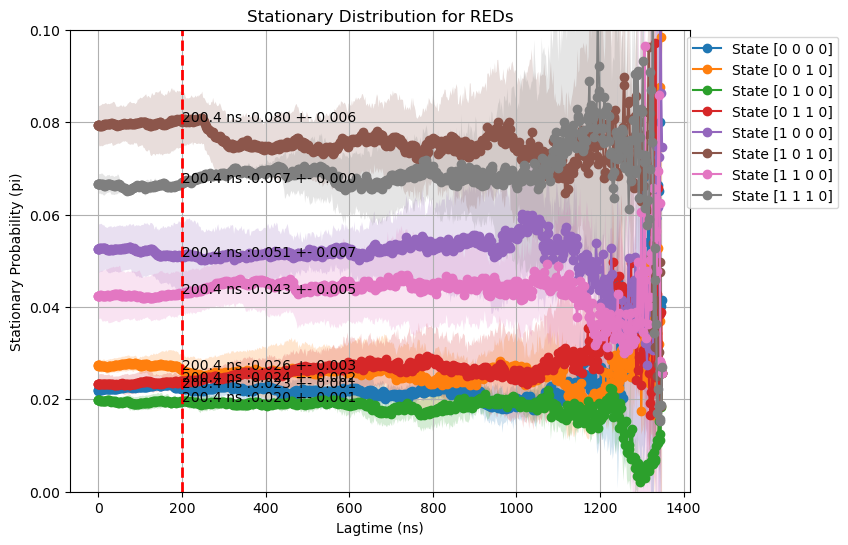

In [9]:
lagtime_plot = 104  # Index of lagtime to annotate
thermo_state = 0
plt.figure(figsize=(8, 6))
state_to_plot = (np.arange(0, 24, 3) + thermo_state).tolist()

# Loop through selected states and plot each separately
for i, state in enumerate(state_to_plot):
    plt.plot(lagtimes_ns, pi_all_means[:, state], '-o', label=f'State {index_to_state(state)}')
        
    # Add shaded region for standard deviation
    plt.fill_between(lagtimes_ns, 
                     pi_all_means[:, state] + pi_all_stds[:, state],  # Upper bound
                     pi_all_means[:, state] - pi_all_stds[:, state],  # Lower bound
                     alpha=0.2)
    
    # Annotate the first point with its value
    first_x = lagtimes_ns[lagtime_plot]
    first_y = pi_all_means[lagtime_plot, state]
    first_y_var = pi_all_stds[lagtime_plot, state]
    plt.text(first_x, first_y,  f"{first_x} ns :{first_y:.3f} +- {first_y_var:.3f}", fontsize=10)
    print(f"{first_x} ns :{first_y:.3f} +- {first_y_var:.3f}")

plt.axvline(x=first_x, color='r', linestyle='--', linewidth=2)
plt.xlabel('Lagtime (ns)')
plt.ylabel('Stationary Probability (pi)')
plt.title('Stationary Distribution for REDs')
plt.ylim(0, 0.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.grid(True)
plt.show()


In [17]:
## Separate each thermo state from the population and normalize those number 

state_index = np.arange(0, 24, 3).tolist()
state_index = np.array(state_index)

state_num = 3
cis_trans_pi_means = []  # To store each (3, 604, 2)
cis_trans_pi_stds = []

for state in range(state_num):
    index = state_index + state

    # Extract columns from the second dimension
    pi_means = pi_all_means[:, index]
    pi_stds = pi_all_stds[:, index]
    print(pi_means.shape)

    # Compute row sums
    row_sums = pi_means.sum(axis=1, keepdims=True)
    # Renormalize the mean
    pi_means /= row_sums
    # Renormalize the standard deviation
    pi_stds /= row_sums

    # Print shapes to confirm correctness
    print(f"pi_means shape: {pi_means.shape}")  # Expected: (4, 8)
    print(f"pi_stds shape: {pi_stds.shape}")  # Expected: (4, 8)

    # Store each normalized pair
    cis_trans_pi_means.append(pi_means)
    cis_trans_pi_stds.append(pi_stds)

# Stack results into shape: (6, 3, 604, 2)
cis_trans_pi_means = np.stack(np.array(cis_trans_pi_means), axis=0)
cis_trans_pi_stds = np.stack(np.array(cis_trans_pi_stds), axis=0)

print("cis_trans_pi_means shape:", cis_trans_pi_means.shape)
print("cis_trans_pi_stds shape:", cis_trans_pi_stds.shape)

#cis_trans_pi_means

(679, 8)
pi_means shape: (679, 8)
pi_stds shape: (679, 8)
(679, 8)
pi_means shape: (679, 8)
pi_stds shape: (679, 8)
(679, 8)
pi_means shape: (679, 8)
pi_stds shape: (679, 8)
cis_trans_pi_means shape: (3, 679, 8)
cis_trans_pi_stds shape: (3, 679, 8)


In [18]:
# === Setup ===
point_to_plot = 400
lagtime_plot = 102  # Index of lagtime (e.g., ~20 ns)
selected_ns = lagtimes_ns[lagtime_plot]

thermo_state_num = 3
conform_state_num = 8

output_dir = "autocoorel_data"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

data_rows = []

# === Loop through all thermo and conformational states ===
for thermo in range(thermo_state_num):
    for conform in range(conform_state_num):
        mean_curve = cis_trans_pi_means[thermo, :, conform]  # shape: (604,)
        std_curve = cis_trans_pi_stds[thermo, :, conform]    # shape: (604,)

        mean_val = mean_curve[lagtime_plot]
        std_val = std_curve[lagtime_plot]

        data_rows.append({
            'thermo_state': thermo,
            'conform_state': conform,
            'lagtime_index': lagtime_plot,
            'lagtime_ns': selected_ns,
            'mean': mean_val,
            'std': std_val
        })

# === Save to CSV ===
df = pd.DataFrame(data_rows)
output_path = os.path.join(output_dir, "trans_population_at_lagtime_8conforms.csv")
df.to_csv(output_path, index=False)

print(f"✅ Saved data to: {output_path}")
df

✅ Saved data to: autocoorel_data/trans_population_at_lagtime_8conforms.csv


,thermo_state,conform_state,lagtime_index,lagtime_ns,mean,std
0,0,0,102,196.4,0.067678,0.004323
1,0,1,102,196.4,0.079729,0.009796
2,0,2,102,196.4,0.058322,0.003529
3,0,3,102,196.4,0.071927,0.005115
4,0,4,102,196.4,0.152803,0.022087
5,0,5,102,196.4,0.241337,0.018221
6,0,6,102,196.4,0.128435,0.013706
7,0,7,102,196.4,0.199770,0.001452
8,1,0,102,196.4,0.064022,0.001785
9,1,1,102,196.4,0.093428,0.006494


/var/folders/d8/y2dvs1ln1gjcwccrkvtffr240000gn/T/ipykernel_8972/140787204.py:16: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 10000)


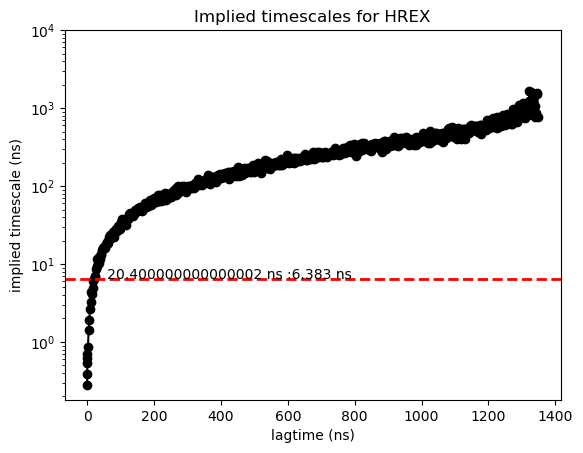

In [12]:
dt_in_ns = 0.004

plt.figure()
plt.plot(lagtimes_ns, t2_all_means*dt_in_ns, 'ko-')
plt.fill_between(lagtimes_ns, t2_all_uppers*dt_in_ns, t2_all_lowers*dt_in_ns, alpha=0.2)
plt.xlabel('lagtime (ns)')
plt.ylabel('implied timescale (ns)')

first_x = lagtimes_ns[14]
first_y = t2_all_means[14] * dt_in_ns
first_y_var = t2_all_stds[14]
plt.text(first_x, first_y, f"   {first_x} ns :{first_y:.3f} ns", fontsize=10)
plt.axhline(y=first_y, color='r', linestyle='--', linewidth=2)

plt.yscale('log')
plt.ylim(0, 10000)
plt.title(f'Implied timescales for HREX')
plt.show()


### Plot 6 state

In [13]:
import numpy as np

def index_to_state(index):
    """
    Converts an index (0..47) into a (4,) array where the first three
    entries are bits (0 or 1) and the last entry is in [0..5].
    
    The logic is inverse of:
        index = 24*a + 12*b + 6*c + x,
    where a, b, c ∈ {0,1} and x ∈ [0..5].
    """
    if not (0 <= index < 48):
        raise ValueError(f"Index out of range: {index}. Expected 0..47.")
    
    # Extract the last element in [0..5]
    x = index % 6

    # The 3-bit portion is the integer in [0..7]
    binary_index = index // 6  # in [0..7]

    # Convert that integer into a 3-bit binary string, e.g. '011'
    binary_str = format(binary_index, '03b')

    # Parse into bits [a, b, c]
    bits = np.array([int(bit) for bit in binary_str], dtype=int)

    # Combine bits and x => [a, b, c, x]
    state = np.concatenate([bits, [x]])

    return state


In [14]:
omega_loaded = Data.load("autocoorel_data/stationary_distributions.pkl").array_list
pi_all_means = omega_loaded[0]
pi_all_uppers = omega_loaded[1]
pi_all_lowers = omega_loaded[2]
pi_all_stds = omega_loaded[3]
t2_all_means = omega_loaded[4]
t2_all_uppers = omega_loaded[5]
t2_all_lowers = omega_loaded[6]
t2_all_stds = omega_loaded[7]
lagtimes_ns = omega_loaded[8]

pi_all_means.shape

(679, 24)

In [15]:
state_index = np.arange(0, 24, 3).tolist()
state_index = np.array(state_index)

state_num = 3
cis_trans_pi_means = []  # To store each (3, 604, 2)
cis_trans_pi_stds = []

for state in range(state_num):
    index = state_index + state

    # Extract columns from the second dimension
    pi_means = pi_all_means[:, index]
    pi_stds = pi_all_stds[:, index]
    print(pi_means.shape)

    # Compute row sums
    row_sums = pi_means.sum(axis=1, keepdims=True)
    # Renormalize the mean
    pi_means /= row_sums
    # Renormalize the standard deviation
    pi_stds /= row_sums

    # Print shapes to confirm correctness
    print(f"pi_means shape: {pi_means.shape}")  # Expected: (4, 8)
    print(f"pi_stds shape: {pi_stds.shape}")  # Expected: (4, 8)

    # Store each normalized pair
    cis_trans_pi_means.append(pi_means)
    cis_trans_pi_stds.append(pi_stds)

# Stack results into shape: (6, 3, 604, 2)
cis_trans_pi_means = np.stack(np.array(cis_trans_pi_means), axis=0)
cis_trans_pi_stds = np.stack(np.array(cis_trans_pi_stds), axis=0)

print("cis_trans_pi_means shape:", cis_trans_pi_means.shape)
print("cis_trans_pi_stds shape:", cis_trans_pi_stds.shape)

#cis_trans_pi_means

(679, 8)
pi_means shape: (679, 8)
pi_stds shape: (679, 8)
(679, 8)
pi_means shape: (679, 8)
pi_stds shape: (679, 8)
(679, 8)
pi_means shape: (679, 8)
pi_stds shape: (679, 8)
cis_trans_pi_means shape: (3, 679, 8)
cis_trans_pi_stds shape: (3, 679, 8)


Thermo 0, Conf 0: 96.40 ns : 0.068
Thermo 0, Conf 1: 96.40 ns : 0.083
Thermo 0, Conf 2: 96.40 ns : 0.057
Thermo 0, Conf 3: 96.40 ns : 0.071
Thermo 0, Conf 4: 96.40 ns : 0.157
Thermo 0, Conf 5: 96.40 ns : 0.239
Thermo 0, Conf 6: 96.40 ns : 0.127
Thermo 0, Conf 7: 96.40 ns : 0.198


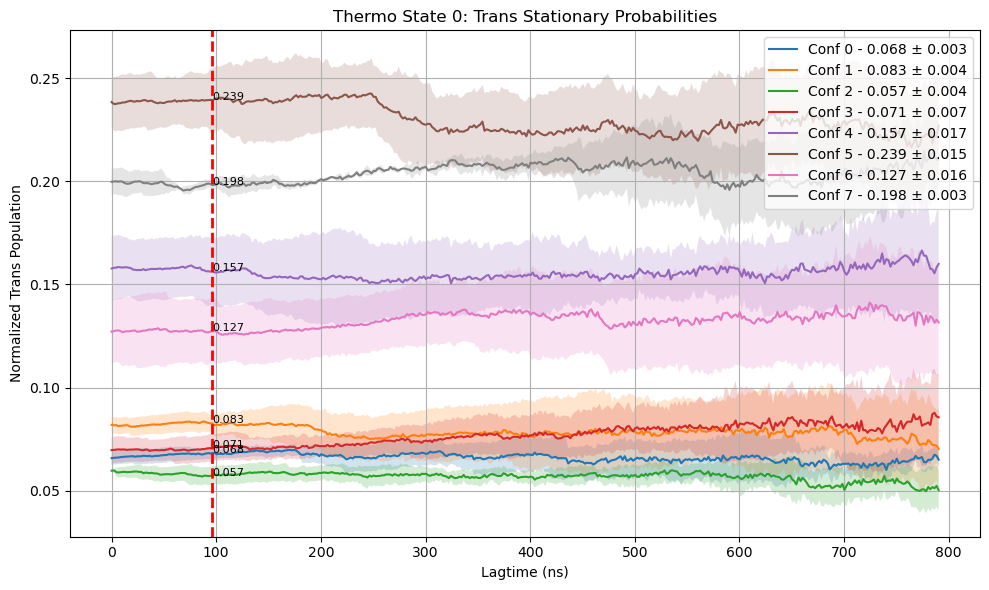

Thermo 1, Conf 0: 96.40 ns : 0.064
Thermo 1, Conf 1: 96.40 ns : 0.096
Thermo 1, Conf 2: 96.40 ns : 0.058
Thermo 1, Conf 3: 96.40 ns : 0.074
Thermo 1, Conf 4: 96.40 ns : 0.152
Thermo 1, Conf 5: 96.40 ns : 0.236
Thermo 1, Conf 6: 96.40 ns : 0.134
Thermo 1, Conf 7: 96.40 ns : 0.187


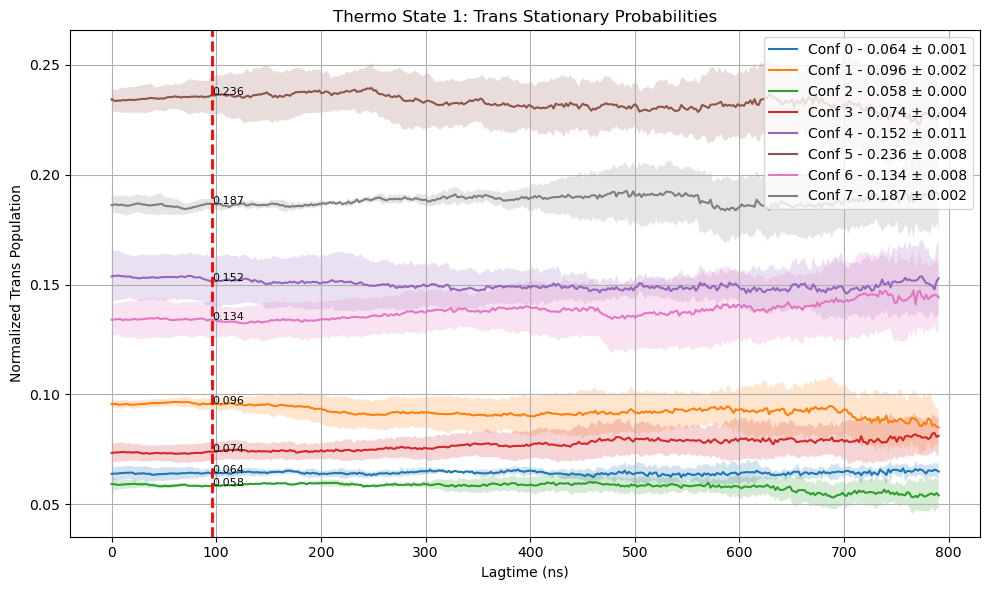

Thermo 2, Conf 0: 96.40 ns : 0.062
Thermo 2, Conf 1: 96.40 ns : 0.098
Thermo 2, Conf 2: 96.40 ns : 0.066
Thermo 2, Conf 3: 96.40 ns : 0.088
Thermo 2, Conf 4: 96.40 ns : 0.137
Thermo 2, Conf 5: 96.40 ns : 0.210
Thermo 2, Conf 6: 96.40 ns : 0.142
Thermo 2, Conf 7: 96.40 ns : 0.197


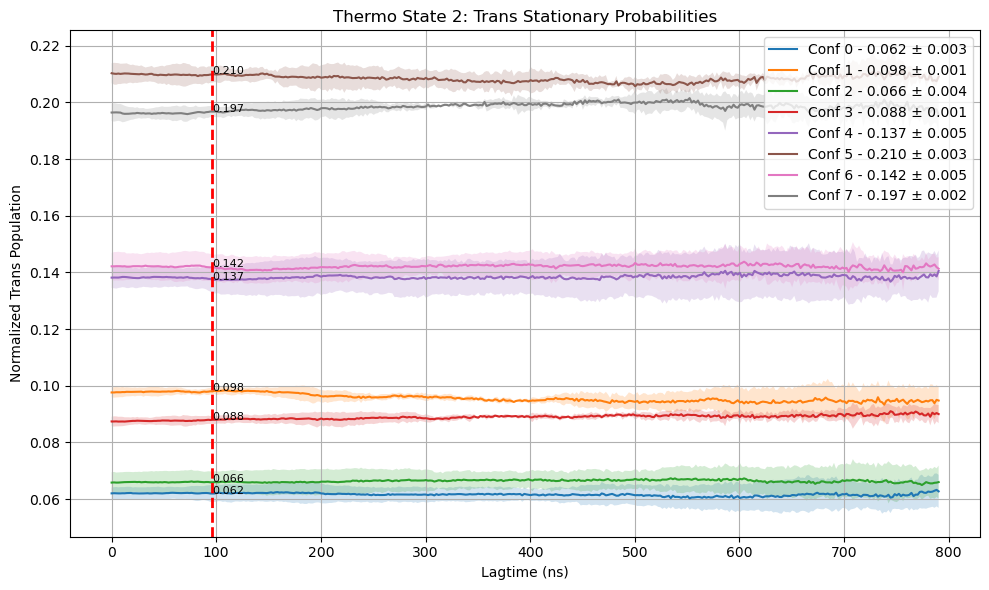

In [16]:
point_to_plot = 400
lagtime_plot = 52  # Index of lagtime to annotate

thermo_state_num = 3
comform_state_num = 8

for thermo in range(thermo_state_num):
    plt.figure(figsize=(10, 6))

    for conform in range(comform_state_num):
        res = cis_trans_pi_means[thermo, :point_to_plot, conform]  # shape (point_to_plot,)
        std = cis_trans_pi_stds[thermo, :point_to_plot, conform]  # shape (point_to_plot,)

        plt.plot(
            lagtimes_ns[:point_to_plot],
            res,
            label=f"Conf {conform} - {res[lagtime_plot]:.3f} ± {std[lagtime_plot]:.3f}"
        )

        plt.fill_between(
            lagtimes_ns[:point_to_plot],
            res + std,
            res - std,
            alpha=0.2
        )

        # Annotate point at selected lagtime
        x_val = lagtimes_ns[lagtime_plot]
        y_val = res[lagtime_plot]
        plt.text(x_val, y_val, f"{y_val:.3f}", fontsize=8)

        print(f"Thermo {thermo}, Conf {conform}: {x_val:.2f} ns : {y_val:.3f}")

    plt.axvline(x=lagtimes_ns[lagtime_plot], color='r', linestyle='--', linewidth=2)
    plt.title(f"Thermo State {thermo}: Trans Stationary Probabilities")
    plt.xlabel("Lagtime (ns)")
    plt.ylabel("Normalized Trans Population")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
# === Setup ===
point_to_plot = 400
lagtime_plot = 54  # Index of lagtime (e.g., ~101 ns)
selected_ns = lagtimes_ns[lagtime_plot]

thermo_state_num = 3
conform_state_num = 8

output_dir = "autocoorel_data"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

data_rows = []

# === Loop through all thermo and conformational states ===
for thermo in range(thermo_state_num):
    for conform in range(conform_state_num):
        mean_curve = cis_trans_pi_means[thermo, :, conform]  # shape: (604,)
        std_curve = cis_trans_pi_stds[thermo, :, conform]    # shape: (604,)

        mean_val = mean_curve[lagtime_plot]
        std_val = std_curve[lagtime_plot]

        data_rows.append({
            'thermo_state': thermo,
            'conform_state': conform,
            'lagtime_index': lagtime_plot,
            'lagtime_ns': selected_ns,
            'mean': mean_val,
            'std': std_val
        })

# === Save to CSV ===
df = pd.DataFrame(data_rows)
output_path = os.path.join(output_dir, "trans_population_at_lagtime_8conforms.csv")
df.to_csv(output_path, index=False)

print(f"✅ Saved data to: {output_path}")
df

✅ Saved data to: autocoorel_data/trans_population_at_lagtime_8conforms.csv


,thermo_state,conform_state,lagtime_index,lagtime_ns,mean,std
0,0,0,54,10.4,0.125,0.000000e+00
1,0,1,54,10.4,0.125,0.000000e+00
2,0,2,54,10.4,0.125,0.000000e+00
3,0,3,54,10.4,0.125,0.000000e+00
4,0,4,54,10.4,0.125,0.000000e+00
5,0,5,54,10.4,0.125,0.000000e+00
6,0,6,54,10.4,0.125,0.000000e+00
7,0,7,54,10.4,0.125,0.000000e+00
8,1,0,54,10.4,0.125,0.000000e+00
9,1,1,54,10.4,0.125,0.000000e+00
